#  main program for ICM-DOM-PD for python
#  a highly modularized code based on Cerco and Coel 1993 estuarine model
#  of Chesapeake Bay

#  Modified from Clark et al. 2020 to include more complex
#  light reactions and photochemistry

In [1]:
import os
import sys
# Find where we are on the computer and make sure it is the pyICM directory
# HomeDir = os.path.expanduser('~')  # get the home directory
HomeDir=os.getcwd()
#can edit below if installing locally, but HomeDir will not be specified for use in binder
# ICMDir = HomeDir + "/Desktop/pyICM-main
ICMDir = HomeDir
# Navigate to the home directory
os.chdir(ICMDir)
print('Moved to Directory',ICMDir)

module_path = os.path.join(ICMDir,'code')
print('Code Directory is',module_path)
print('Adding to the system path')
if module_path not in sys.path:
    sys.path.append(module_path)
    # Common python libraries needed for this code
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# IMPORT ALL OF THE LIBRARIES AND FILES USED FOR ICM
import Density
import functions
import DefVars as dv
import Light
import Sediment as sed
import Nutrients as nt
import DOM
import POM
import Algae
import Oxygen
import glob
from scipy.ndimage.filters import uniform_filter1d
from IPython.display import display, HTML  
print('Successfully imported all Modules')

Moved to Directory /Users/jbclark8/Desktop/pyICM-main_binder
Code Directory is /Users/jbclark8/Desktop/pyICM-main_binder/code
Adding to the system path
Successfully imported all Modules


In [9]:
WhichData = 'Chesapeake'
StatDir = ICMDir+"/Inputs/"+WhichData

print(StatDir)
StatFiles = sorted(glob.glob(StatDir+"/CBP/*.csv"))

print("These are the following files available")

# Show all available files
ii = 0
for ff in StatFiles:
    f1 = ff.split('/')
    f1 = f1[len(f1)-1]
    f1 = f1.split("_")

    print(ii+1, ". ", f1[0])

    ii = ii+1

fnum = int(input("Which station file from the list would you like to run?"
                 "\n'"
                 "Enter  the integer number from the file list below here then hit enter ---> "))

WQ_fname = StatFiles[fnum-1]
print("File Selected is --> ", WQ_fname)

/Users/jbclark8/Desktop/pyICM-main_binder/Inputs/Chesapeake
These are the following files available
1 .  CB1.1
2 .  CB2.1
3 .  CB2.2
4 .  CB3.1
5 .  CB3.2
6 .  CB3.3C
7 .  CB4.1C
8 .  CB4.2C
9 .  CB4.3C
10 .  CB4.4
11 .  CB5.1
12 .  CB5.2
13 .  CB5.3
14 .  CB5.4
15 .  CB5.5
16 .  CB6.1
17 .  CB6.2
18 .  CB6.3
19 .  CB6.4
20 .  CB7.1
21 .  CB7.2
22 .  CB7.3
23 .  CB7.4
24 .  CB8.1
Which station file from the list would you like to run?
'Enter  the integer number from the file list below here then hit enter ---> 20
File Selected is -->  /Users/jbclark8/Desktop/pyICM-main_binder/Inputs/Chesapeake/CBP/CB7.1_Climatology.csv


In [10]:
print("Hello! Welcome to ICM." "\n"
      "This current version is for Chesapeake Bay" "\n"
      "Station data is read variables are dynamically calculated. This is version 0.1")

Hello! Welcome to ICM.
This current version is for Chesapeake Bay
Station data is read variables are dynamically calculated. This is version 0.1


In [11]:
# get the station name from the file name, to match the weather data
Fin = WQ_fname.split('/')
Fin = Fin[len(Fin)-1]
Fin = Fin.split('_')
StatName = Fin[0]

LAT = 38
LON = -76
yy = 2020

In [12]:
# read in the time series data  of water quality inputs
myTS = pd.read_csv(WQ_fname)
myTS.head()
# read in spectral information for light attenuation
Light_fname = StatDir + "/CBay_Spectral.csv"
myLT = pd.read_csv(Light_fname)

# read in surface forcing information for light and weather
weather_fname = StatDir+"/Weather/"+StatName+"_Weather.csv"
mySFC = pd.read_csv(weather_fname)

In [13]:
errorcode = dv.InitializeVariables()
if(errorcode == 1):
    print('All variables were not defined, there is a problem and ICM is\
          stopping')
elif(errorcode == 0):
    print('All global variables have been defined')

All global variables have been defined


# First we have to define the space and time dimensions
# We can change the spatial dimensions if need be, by default
# the are 10 km x 10 km x 10 m
# dv is the DefVars module which contains the values for all of the global
# parameters. In there the user can find many parameters of interest.

In [14]:
print('X= ',dv.X, ' m, Y= ', dv.Y,' m, Z= ',dv.Z,' m ')
# calculate the domain volume, specified in DefVars
Volume = functions.CalcVolume(dv.X, dv.Y, dv.Z)
print('Volume =', Volume*1e-9, 'km^3')

# now set up the time vector for integration, using the forcing file time
modtimein = myTS.Time
lasttime = modtimein[len(modtimein)-1]
print('Start and End Days are = ', modtimein[0]/86400, lasttime/86400)

X=  10000.0  m, Y=  10000.0  m, Z=  10.0  m 
Volume = 1.0 km^3
Start and End Days are =  1.0 365.0


In [15]:
# set the time step here
DT = 3600.
Nsteps = int(lasttime/DT)

# now set up a time array with the appropriate time step
modtime = np.linspace(modtimein[0], lasttime, Nsteps)
current_time = modtime[0]

print('My Time Step is = ', DT, 'Seconds')
#total number of time steps
mylen = len(modtime)

My Time Step is =  3600.0 Seconds


# Now we will read in the station data as "River" forcing
# the weather data as the surface forcing
# and the spectral parameterization for the light calculations

# Some suggested experiments are 
# Change the river input flow (static currently)
# Change the river input concentrations
# The river input temperature
# The wind velocity
# Or the surface temperature

In [16]:
# RIVER FLOW
Q = np.ones(mylen)*500.
# RIVER INPUTS
# Water Temperature
Tin = myTS.WTEMP
# Water Salinity
Sin = myTS.SALINITY
# Nitrogen
RivNH4in = myTS.NH4F
RivNO3in = myTS.NO23F
# Convert upstream chl a concentration into algae 1 and 2 carbon
RivAlgae1in = myTS.CHLA*0.5*dv.cchla1*1e-3
RivAlgae2in = myTS.CHLA*0.5*dv.cchla1*1e-3
# calculate the change in concentration due to river inputs
RiverISSin = myTS.TSS

In [17]:
# SURFACE FORCING
# wind velocity
Uin = mySFC.uwnd[0:365]
Vin = mySFC.vwnd[0:365]

# total downwelling shortwave flux and scale by 0.43 to remove IR
EdIn = mySFC.dswrf*0.43

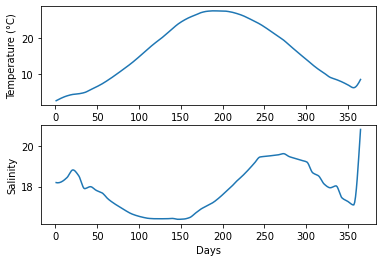

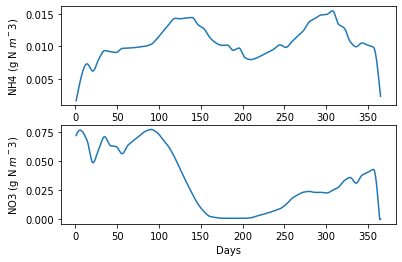

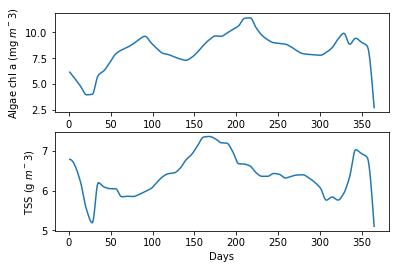

In [18]:
# Make a Figures Directory if not Exist
OutDir = ICMDir + "/Outputs"
FDir = OutDir + '/Figures'

if not os.path.isdir(OutDir):
    path = os.path.join(ICMDir, 'Outputs')
    os.mkdir(path)

if not os.path.isdir(FDir):
    path = os.path.join(OutDir, 'Figures')
    os.mkdir(path)
#now we can plot some of these forcings
# 
Fig1,(ax1,ax2)=plt.subplots(2)
ax1.plot(modtimein/86400,Tin)
ax1.set(xlabel='Days')
ax1.set(ylabel='Temperature (°C)')
ax2.plot(modtimein/86400,Sin)
ax2.set(xlabel='Days')
ax2.set(ylabel='Salinity')
plt.savefig(FDir + '/' + StatName + '_Forcing_TandS.png')
plt.show()
Fig1,(ax1,ax2)=plt.subplots(2)
ax1.plot(modtimein/86400,RivNH4in)
ax1.set(xlabel='Days')
ax1.set(ylabel='NH4 (g N $m{^-3})$')
ax2.plot(modtimein/86400,RivNO3in)
ax2.set(xlabel='Days')
ax2.set(ylabel='NO3 (g N $m{^-3})$')
plt.savefig(FDir + '/' +  StatName + '_Forcing_InorganicNitrogen.png')
plt.show()
Fig1,(ax1,ax2)=plt.subplots(2)
ax1.plot(modtimein/86400,myTS.CHLA)
ax1.set(xlabel='Days')
ax1.set(ylabel='Algae chl a (mg $m{^-3})$')
ax2.plot(modtimein/86400,myTS.TSS)
ax2.set(xlabel='Days')
ax2.set(ylabel='TSS (g $m{^-3})$')
plt.savefig(FDir + '/' + StatName + '_Forcing_ChlaandTSS.png')
plt.show()


In [19]:
# LIGHT PARAMETERS
# wavelengths, nm
WL = myLT.Lambda
# absorption due to water, m^-1
aWater = myLT.aW
# mass specific absorption for each colored DOC, m^2 gC^-1
aC1 = myLT.aCDOC1
aC2 = myLT.aCDOC2
aC3 = myLT.aCDOC3
# take the averge for now
aCDOC = np.average(np.column_stack((aC1, aC2, aC3)), 1)
# mass specific absorption due to chla, m^2 mg chla^-1
aPhi = myLT.aPhi
# mass specific absorption due to particles, m^2 g^-1
aP = myLT.aP
# mass specific backscattering due to particles, m^2 g^-1
bbP = myLT.bbp
# spectral distribution of light, nm^-1
SpecDis = myLT.Spec_dist

In [20]:
# plt.plot(WL,aWater,label="aWater")
# plt.plot(WL,aPhi,label="a*Phi")
# plt.plot(WL,bbP,label="bb*p")
# plt.plot(WL,aP,label="a*P")
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('a*')
# plt.legend()
# plt.show()
# plt.plot(WL,aC1,label="a*CDOC1")
# plt.plot(WL,aC2,label="a*CDOC2")
# plt.plot(WL,aC3,label="a*CDOC3")
# plt.legend()
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('a*C (m^2/gC)')
# plt.show()
# plt.plot(WL,SpecDis)
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Spectral Distribution')

In [21]:
# interpolate all forcing to the model time step
T = np.interp(modtime, modtimein, Tin)
S = np.interp(modtime, modtimein, Sin)
Speed = np.sqrt(Uin ** 2 + Vin ** 2)
Uwind = np.interp(modtime, modtimein, Speed)

RivNH4 = np.interp(modtime, modtimein, RivNH4in)
RivNO3 = np.interp(modtime, modtimein, RivNO3in)
RivAlgae1 = np.interp(modtime, modtimein, RivAlgae1in)
RivAlgae1 = np.interp(modtime, modtimein, RivAlgae2in)
RiverISS = np.interp(modtime, modtimein, RiverISSin)


In [22]:
# %%%%%%%%%%%%%%%% INITIALIZE ALL WATER QUALITY VARIABLES %%%%%%%%%%%%%%%%%%
# After running the model a few times, can take the last value and input here
# phytoplankton 1 and 2 biomass (g C m^-3)
B1 = np.zeros(mylen)
B1[0] = 0.1
B2 = np.zeros(mylen)
B2[0] = 0.1

# phytoplankton 1 and 2 chla
# convert carbon to chla in micrograms L6-1
chla1 = B1 / dv.cchla1 * 1e3
chla2 = B2 / dv.cchla2 * 1e3
chla = chla1 + chla2

# #ammonium and nitrate concentration (g N m^-3)
NH4 = np.zeros(mylen)
NH4[0] = 0.001

NO3 = np.zeros(mylen)
NO3[0] = 0.2


# dissolved oxygeen
DO2 = np.zeros(mylen)
DO2[0] = 10.0

# temp var for DON remineralization
MNLDON = 0.01

# set up an array for KD, PAR, and NP_Total to collect and pass back to main
# from the light attenuation function
KD = np.zeros((mylen, len(WL)))
PAR = np.zeros(mylen)
KD_PAR = np.zeros(mylen)
KD_PAR[0]=1.5
NP_total = np.zeros((mylen, len(WL)))
Rrs_out = np.zeros((mylen, len(WL)))
EdAvg = np.zeros((mylen, len(WL)))
# now find where WL == 400 and WL == 700 to mark off the PAR
dv.PAR_Id[0] = (np.abs(WL - 400.)).argmin()
dv.PAR_Id[1] = (np.abs(WL - 700.)).argmin()

# #colored and non-colored DOC concentration (g C m^-3)
CDOC = np.ones(mylen)
# NCDOC=np.zeros(mylen)
MNLDOC = 0.05
# #colored and non-colored DON concentration (g N m^-3)
# CDON=np.zeros(mylen)
# NCDON=np.zeros(mylen)

# #Labile and Refractory POC and PON in g C and g N m^-3
LPOC = np.zeros(mylen)
LPOC[0] = 0.5
RPOC = np.zeros(mylen)
RPOC[0] = 1.0
# LPON=np.zeros(mylen)
# RPON=np.zeros(mylen)

# inorganic suspended sediment (g m^-3)
ISS = np.zeros(mylen)
ISS[0] = 10.

# TSS = np.zeros(mylen)
TSS = ISS + (LPOC + RPOC) * 2.5

# Phytoplankton Rate Variables
SZA = np.zeros(mylen)
SZAa = np.zeros(mylen)
FI1 = np.zeros(mylen)
FI2 = np.zeros(mylen)
NL1 = np.zeros(mylen)
NL2 = np.zeros(mylen)
NPP1 = np.zeros(mylen)
NPP2 = np.zeros(mylen)
P1 = np.zeros(mylen)
P2 = np.zeros(mylen)
PR1 = np.zeros(mylen)
PR2 = np.zeros(mylen)
PN1 = np.zeros(mylen)
PN2 = np.zeros(mylen)

NT = np.zeros(mylen)


# Now all variables are initialized and all forcing is specified
# The main loop is ready to begin
# The main loop calculates the change in concentration and the new concentration
# over time at time interval DT
# The model is integrated using simple Euler (forward) integration and 
# can therefore be unstable at longer time steps
# A short time step is highly recommended
# the model runs until it reaches the end of the river time series 
# and calls the functions within each module for each dynamic
# water quality constituent

In [ ]:
jj=1
j=2
while jj<j: #this loop sets how many times the model iterates to reach a steady state solution
    current_time = modtime[0]
    print('Running Model simulations')
    i = 1
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% BEGIN MAIN LOOP %%%%%%%%%%%%%%%%%%%%%%%%%%%%
    while current_time < modtime[len(modtime)-1]:

        JDAY = current_time/86400
        MyDay = np.floor(JDAY)

        # calculate the total absorption and the total scattering
        aTotal = (aWater + chla[i-1] * aPhi +
                  CDOC[i-1] * aCDOC +
                  TSS[i-1] * aP)
        bTotal = TSS[i-1] * bbP
        Ed = EdIn[MyDay] * SpecDis
        # call the light attenuation functions
        KD[(i, )], PAR[i], NP_total[(i, )], KD_PAR[i], \
            EdAvg[i], Rrs_out[(i, )], SZA[i], SZAa[i] = \
            Light.Light_Attenuation(WL, Ed,
                                aTotal, bTotal, dv.Z*0.1,
                                JDAY, LAT, LON, yy, T[i], S[i])
        
        #flushing rate based on volume and river flow
        FRate = functions.CalcFlushingRate(Q[i], Volume)
        
        #temperature function for scaling some scalar inputs to match seasonality
        thetaXX=functions.get_ft(0.069,20.0,T[i])
### CALL FUNCTIONS TO CALCULATE CHANGE AT THIS TIME STEP ###
    # calculate the change in concentration due to biogeochemical processes
    # first algal growth and death
        Algae1 = Algae.DTB1(B1[i-1], NH4[i-1], NO3[i-1], T[i],
                        PAR[i], FRate, RivAlgae1[i], Q[i], Volume)
        Algae2 = Algae.DTB2(B2[i-1], NH4[i-1], NO3[i-1], T[i],
                        PAR[i], FRate, RivAlgae1[i], Q[i], Volume)
    # get some of the algae rates
        FI1[i] = Algae1.FI
        FI2[i] = Algae2.FI
        NL1[i] = Algae1.NL
        NL2[i] = Algae2.NL
        NPP1[i] = Algae1.NPP
        NPP2[i] = Algae2.NPP
        P1[i] = Algae1.P1
        P2[i] = Algae2.P2
        PR1[i] = Algae1.PR1
        PR2[i] = Algae2.PR2
        PN1[i] = Algae1.PN
        PN2[i] = Algae2.PN

    # next inorganic nitrogen
        NH4A = Algae1.NH4A+Algae2.NH4A
        NO3A = Algae1.NO3A+Algae2.NO3A

        DTNO3 = nt.DTNO3(NH4[i-1], NO3[i-1], T[i], DO2[i-1], NO3A,
                             Q[i], Volume, FRate, RivNO3[i])
        DTNH4 = nt.DTNH4(NH4[i-1], NO3[i-1], T[i], DO2[i-1], MNLDON*thetaXX,
                     NH4A, Q[i], Volume, FRate, RivNH4[i])
    # nitrification
        NT[i] = nt.Nitrification(NH4[i-1], T[i], DO2[i-1])

    # inorganic sediment
        DTISS = sed.deltaISS(Q[i], Volume, FRate, RiverISS[i], ISS[i-1])

    # next calculate dissolved oxygen
        DTDO2 = Oxygen.DOXG(DO2[i-1], T[i], S[i], dv.Z,
                        PN1[i], PN2[i], P1[i], P2[i], PR1[i],
                        PR2[i], B1[i], B2[i],
                        NT[i], Uwind[i], MNLDOC*thetaXX, 0)
        
### INTEGRATION BLOCK
    #  update the concentrations
        DO2[i] = DO2[i-1] + DTDO2*DT
        #check for impossibly low O2, cant be less <= zero
        #reset if it is
        if DO2[i]<0:
            DO2[i]=1e-3
#         if DO2[i]>12.:
#             DO2[i]=12.
                

        ISS[i] = ISS[i-1]+DTISS*DT

        B1[i] = B1[i-1]+Algae1.DTB1*DT
        B2[i] = B2[i-1]+Algae2.DTB2*DT

        chla1[i] = B1[i] / dv.cchla1 * 1e3
        chla2[i] = B2[i] / dv.cchla2 * 1e3

        chla[i] = chla1[i] + chla2[i]

        NH4[i] = NH4[i-1]+DTNH4.DTNH4*DT
        NO3[i] = NO3[i-1]+DTNO3.DTNO3*DT

        TSS[i] = ISS[i] + B1[i] + B2[i] + (LPOC[i] + RPOC[i]) * 2.5

    # update the time
        current_time = modtime[i]
        i = i+1
    #update the non-time loop
    jj=jj+1    
print('Congratulations!!!','\n'
'Model run is complete, plotting some things now')

Running Model simulations


In [ ]:



# now make some plots of whatever you like and save to the Figures Directory
# plt.plot(modtime/86400, ISS)
# plt.xlabel('Time')
# plt.ylabel('$ISS (g m^{-3})$')
# plt.savefig(FDir + '/ISS_ts.png')
# plt.show()
# Oxygen Difference
N=int(86400/DT*7)
M_Base = uniform_filter1d(PAR, size=N)
plt.plot(modtime/86400, PAR,label='Exact')
plt.plot(modtime/86400,M_Base,label='Weekly Avg')

plt.xlabel('Time')
plt.ylabel('PAR $(W m^{-2})$')
plt.savefig(FDir + '/' + StatName + '_Base_PAR_ts.png')
plt.show()

# plt.plot(modtime/86400, Rrs)
# plt.xlabel('Time')
# plt.ylabel('Rrs $(sr^{-1})$')
# plt.savefig(FDir + '/' + StatName + 'Rrs_calculated_ts.png')
# plt.show()
M_Base = uniform_filter1d(KD_PAR, size=N)
plt.plot(modtime/86400, KD_PAR)
plt.plot(modtime/86400, M_Base)
plt.plot(modtime/86400,modtime*0+1.5,'k')
plt.legend({'Exact','Weekly Avg.','SAV Limit'})
plt.xlabel('Time')
plt.ylabel('Kd $(m^{-1})$')
plt.savefig(FDir + '/' + StatName + '_Base_KD_PAR_ts.png')
plt.show()

# plt.plot(modtime/86400, 90-SZA)
# plt.xlabel('Time')
# plt.ylabel('$SZA(degrees)$')
# plt.savefig(FDir + '/SZA_ts.png')
# plt.show()

M_Base = uniform_filter1d(B1, size=N)
plt.plot(modtime/86400, B1)
plt.plot(modtime/86400, M_Base)
plt.legend({'Exact','Weekly Avg.'})
plt.xlabel('Time')
plt.ylabel('Diatoms $(gC m^{-3})$')
plt.savefig(FDir + '/' + StatName + '_Base_Diatoms_ts.png')
plt.show()

M_Base = uniform_filter1d(B2, size=N)
plt.plot(modtime/86400, B2)
plt.plot(modtime/86400, M_Base)
plt.legend({'Exact','Weekly Avg.'})
plt.xlabel('Time')
plt.ylabel('Dinoflagellates $(gC m^{-3})$')
plt.savefig(FDir + '/' + StatName + '_Base_Dinoflagellates_ts.png')
plt.show()

M_Base = uniform_filter1d(NH4, size=N)
plt.plot(modtime/86400, NH4)
plt.plot(modtime/86400, M_Base)
plt.legend({'Exact','Weekly Avg.'})
plt.xlabel('Time')
plt.ylabel('NH4 (g N $m^{-3})$')
plt.savefig(FDir + '/' + StatName + '_Base_NH4_ts.png')
plt.show()

M_Base = uniform_filter1d(NO3, size=N)
plt.plot(modtime/86400, NO3)
plt.plot(modtime/86400, M_Base)
plt.legend({'Exact','Weekly Avg.'})
plt.xlabel('Time')
plt.ylabel('NO3 (g N $m^{-3})$')
plt.savefig(FDir + '/' + StatName + '_Base_NO3_ts.png')
plt.show()

M_Base = uniform_filter1d(DO2, size=N)
plt.plot(modtime/86400, DO2)
plt.plot(modtime/86400, M_Base)
plt.legend({'Exact','Weekly Avg.'})
plt.xlabel('Time')
plt.ylabel('$O2 (g m^{-3})$')
plt.savefig(FDir + '/' + StatName + '_Base_DissolvedOxygen_ts.png')
plt.show()

M_Base = uniform_filter1d(NPP1+NPP2, size=N)
plt.plot(modtime/86400, NPP1+NPP2)
plt.plot(modtime/86400, M_Base)
plt.legend({'Exact','Weekly Avg.'})
plt.xlabel('Time')
plt.ylabel('Net Primary Production (g C $m^{-2}$ $d^{-1})$')
plt.savefig(FDir + '/' + StatName + '_Base_NPP_ts.png')
plt.show()

# plt.plot(modtime/86400, NPP2)
# plt.xlabel('Time')
# plt.ylabel('$Algae 2 NPP (g C m^{-2} d^{-1})$')
# plt.savefig(FDir + '/NPP_ts.png')
# plt.show()


print('Model Run is All Done, You Can Find Plots in the Outputs/Figures Directory')

In [ ]:

# Now take calculate some statistics for our stations and compile them into a table
PAR_mean=np.mean(PAR)
PAR_max=np.max(PAR)
PAR_min=np.min(PAR)
PAR_total=np.nan

KD_mean=np.mean(KD_PAR)
KD_max=np.max(KD_PAR)
KD_min=np.min(KD_PAR)
KD_total=np.nan

B1_mean=np.mean(B1)
B1_max=np.max(B1)
B1_min=np.min(B1)
B1_total=np.mean(B1)*Volume

B2_mean=np.mean(B2)
B2_max=np.max(B2)
B2_min=np.min(B2)
B2_total=np.mean(B2)*Volume

NPP_mean=np.mean(NPP1+NPP2)
NPP_max=np.max(NPP1+NPP2)
NPP_min=np.min(NPP1+NPP2)
NPP_total=np.trapz((NPP1+NPP2)/86400,modtime)

#Now compile all of the statistics into a pandas dataframe for display, 

# just simple statistics for now
ColumnLabels=['PAR (W/m2)','KD (1/m)','Diatoms (gC/m3)','Dinoflagellates (gC/m3)','NPP (gC/m2/d)']
RowLabels=['Baseline Mean','Baseline Max','Baseline Min','Baseline Total (Gg C)']
#make an array that we can pile in the data
Stats_Data=np.transpose(np.array([(PAR_mean,PAR_max,PAR_min,PAR_total),(KD_mean,KD_max,KD_min,KD_total) ,(B1_mean,B1_max,B1_min,B1_total),(B2_mean,B2_max,B2_min,B2_total) ,(NPP_mean,NPP_max,NPP_min,NPP_total)]))
# Stats_Data.append([Diatom_Stats,Dino_Stats,O2_Stats,NPP_Stats,KD_Stats])
#convert to a dataframe for display
stats_df=pd.DataFrame(Stats_Data,columns=ColumnLabels)
stats_df.index=RowLabels
# stats_df.append(Stats_Data)
# stats_df.DataFrame()
display(stats_df)

stats_df.to_csv(FDir + '/' + StatName + '_Baseline_Statistics.csv')

In [ ]:

# now we will reRun the code Again but we can change the model forcing
# #first we will put the variables we care to a different array

In [ ]:

# # defined now as Base
B1_Base=B1
B2_Base=B2
chla1_Base=chla1
chla2_Base=chla2
NO3_Base=NO3
NH4_Base=NH4
NPP1_Base=NPP1
NPP2_Base=NPP2
DO2_Base=DO2
KD_Base=KD_PAR

In [ ]:
# %%%%%%%%%%%%%%%% INITIALIZE ALL WATER QUALITY VARIABLES %%%%%%%%%%%%%%%%%%
# After running the model a few times, can take the last value and input here
# phytoplankton 1 and 2 biomass (g C m^-3)
B1 = np.zeros(mylen)
B1[0] = 0.1
B2 = np.zeros(mylen)
B2[0] = 0.1

# phytoplankton 1 and 2 chla
# convert carbon to chla in micrograms L6-1
chla1 = B1 / dv.cchla1 * 1e3
chla2 = B2 / dv.cchla2 * 1e3
chla = chla1 + chla2

# #ammonium and nitrate concentration (g N m^-3)
NH4 = np.zeros(mylen)
NH4[0] = 0.001

NO3 = np.zeros(mylen)
NO3[0] = 0.2


# dissolved oxygeen
DO2 = np.zeros(mylen)
DO2[0] = 10.0

# temp var for DON remineralization
MNLDON = 0.01

# set up an array for KD, PAR, and NP_Total to collect and pass back to main
# from the light attenuation function
KD = np.zeros((mylen, len(WL)))
PAR = np.zeros(mylen)
KD_PAR = np.zeros(mylen)
KD_PAR[0]=1.5
NP_total = np.zeros((mylen, len(WL)))
Rrs_out = np.zeros((mylen, len(WL)))
EdAvg = np.zeros((mylen, len(WL)))
# now find where WL == 400 and WL == 700 to mark off the PAR
dv.PAR_Id[0] = (np.abs(WL - 400.)).argmin()
dv.PAR_Id[1] = (np.abs(WL - 700.)).argmin()

# #colored and non-colored DOC concentration (g C m^-3)
CDOC = np.ones(mylen)
# NCDOC=np.zeros(mylen)
MNLDOC = 0.05
# #colored and non-colored DON concentration (g N m^-3)
# CDON=np.zeros(mylen)
# NCDON=np.zeros(mylen)

# #Labile and Refractory POC and PON in g C and g N m^-3
LPOC = np.zeros(mylen)
LPOC[0] = 0.5
RPOC = np.zeros(mylen)
RPOC[0] = 1.0
# LPON=np.zeros(mylen)
# RPON=np.zeros(mylen)

# inorganic suspended sediment (g m^-3)
ISS = np.zeros(mylen)
ISS[0] = 10.

# TSS = np.zeros(mylen)
TSS = ISS + (LPOC + RPOC) * 2.5

# Phytoplankton Rate Variables
SZA = np.zeros(mylen)
SZAa = np.zeros(mylen)
FI1 = np.zeros(mylen)
FI2 = np.zeros(mylen)
NL1 = np.zeros(mylen)
NL2 = np.zeros(mylen)
NPP1 = np.zeros(mylen)
NPP2 = np.zeros(mylen)
P1 = np.zeros(mylen)
P2 = np.zeros(mylen)
PR1 = np.zeros(mylen)
PR2 = np.zeros(mylen)
PN1 = np.zeros(mylen)
PN2 = np.zeros(mylen)

NT = np.zeros(mylen)

In [ ]:
# now re-parameterize some of the Forcing
# this will be an example of what happens if we cut 
# inorganic nitrogen input by 75%
#### HERE ARE THE FORCING INPUTS THAT CAN BE MODIFIED FOR THE SCENARIO
    
RivNH4_reduced=RivNH4*0.25
RivNO3_reduced=RivNO3*0.25

jj=1
j=2
while jj<j: #this loop sets how many times the model iterates to reach a steady state solution
    current_time = modtime[0]
    print('Running Model simulations')
    i = 1
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% BEGIN MAIN LOOP %%%%%%%%%%%%%%%%%%%%%%%%%%%%
    while current_time < modtime[len(modtime)-1]:

        JDAY = current_time/86400
        MyDay = np.floor(JDAY)

        # calculate the total absorption and the total scattering
        aTotal = (aWater + chla[i-1] * aPhi +
                  CDOC[i-1] * aCDOC +
                  TSS[i-1] * aP)
        bTotal = TSS[i-1] * bbP
        Ed = EdIn[MyDay] * SpecDis
        # call the light attenuation functions
        KD[(i, )], PAR[i], NP_total[(i, )], KD_PAR[i], \
            EdAvg[i], Rrs_out[(i, )], SZA[i], SZAa[i] = \
            Light.Light_Attenuation(WL, Ed,
                                aTotal, bTotal, dv.Z*0.1,
                                JDAY, LAT, LON, yy, T[i], S[i])

        #flushing rate based on volume and river flow
        FRate = functions.CalcFlushingRate(Q[i], Volume)
        
        #temperature function for scaling some scalar inputs to match seasonality
        thetaXX=functions.get_ft(0.069,20.0,T[i])
        
### CALL FUNCTIONS TO CALCULATE CHANGE AT THIS TIME STEP ###
    # calculate the change in concentration due to biogeochemical processes
    # first algal growth and death
        Algae1 = Algae.DTB1(B1[i-1], NH4[i-1], NO3[i-1], T[i],
                        PAR[i], FRate, RivAlgae1[i], Q[i], Volume)
        Algae2 = Algae.DTB2(B2[i-1], NH4[i-1], NO3[i-1], T[i],
                        PAR[i], FRate, RivAlgae1[i], Q[i], Volume)
    # get some of the algae rates
        FI1[i] = Algae1.FI
        FI2[i] = Algae2.FI
        NL1[i] = Algae1.NL
        NL2[i] = Algae2.NL
        NPP1[i] = Algae1.NPP
        NPP2[i] = Algae2.NPP
        P1[i] = Algae1.P1
        P2[i] = Algae2.P2
        PR1[i] = Algae1.PR1
        PR2[i] = Algae2.PR2
        PN1[i] = Algae1.PN
        PN2[i] = Algae2.PN

    # next inorganic nitrogen
        NH4A = Algae1.NH4A+Algae2.NH4A
        NO3A = Algae1.NO3A+Algae2.NO3A

        DTNO3 = nt.DTNO3(NH4[i-1], NO3[i-1], T[i], DO2[i-1], NO3A,
                             Q[i], Volume, FRate, RivNO3_reduced[i])
        DTNH4 = nt.DTNH4(NH4[i-1], NO3[i-1], T[i], DO2[i-1], MNLDON*thetaXX,
                     NH4A, Q[i], Volume, FRate, RivNH4_reduced[i])
    # nitrification
        NT[i] = nt.Nitrification(NH4[i-1], T[i], DO2[i-1])

    # inorganic sediment
        DTISS = sed.deltaISS(Q[i], Volume, FRate, RiverISS[i], ISS[i-1])

    # next calculate dissolved oxygen
        DTDO2 = Oxygen.DOXG(DO2[i-1], T[i], S[i], dv.Z,
                        PN1[i], PN2[i], P1[i], P2[i], PR1[i],
                        PR2[i], B1[i], B2[i],
                        NT[i], Uwind[i], MNLDOC*thetaXX, 0)
        
### INTEGRATION BLOCK
    #  update the concentrations
        DO2[i] = DO2[i-1] + DTDO2*DT
        if DO2[i]<0:
            DO2[i]=1e-3
            
        ISS[i] = ISS[i-1]+DTISS*DT

        B1[i] = B1[i-1]+Algae1.DTB1*DT
        B2[i] = B2[i-1]+Algae2.DTB2*DT

        chla1[i] = B1[i] / dv.cchla1 * 1e3
        chla2[i] = B2[i] / dv.cchla2 * 1e3

        chla[i] = chla1[i] + chla2[i]

        NH4[i] = NH4[i-1]+DTNH4.DTNH4*DT
        NO3[i] = NO3[i-1]+DTNO3.DTNO3*DT

        TSS[i] = ISS[i] + B1[i] + B2[i] + (LPOC[i] + RPOC[i]) * 2.5

    # update the time
        current_time = modtime[i]
        i = i+1
    #update the non-time loop
    jj=jj+1    
print('Congratulations!!!','\n'
'Model run is complete, plotting some things now')

In [ ]:
# now plot the comparison between the baseline and the nutrient reduction


# Stats.Diatoms.Mean=[]
l1='Baseline'
l2='75% Decrease'
l3='Difference'
# Algae Difference
#Take the daily running mean to remove short frequency oscillations
#found this one https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
N=int(86400/DT) # Number of time steps in the day

M_Base = uniform_filter1d(B1_Base, size=N)
M_scenario = uniform_filter1d(B1, size=N)

M1=np.mean(M_Base)
M2=np.mean(M_scenario)
Diatom_Stats=[M1,M2,(M2-M1)/M1*100]

Fig1,(ax1,ax2)=plt.subplots(2)
ax1.plot(modtime/86400, M_Base)
ax1.plot(modtime/86400, M_scenario)
ax1.plot(modtime/86400,M_Base-M_scenario)
ax1.legend([l1,l2,l3])
# ax1.legend({'75% decrease'})
ax1.set(ylabel='Diatoms (gC $m^{-3})$')

M_Base = uniform_filter1d(B2_Base, size=N)
M_scenario = uniform_filter1d(B2, size=N)
M1=np.mean(M_Base)
M2=np.mean(M_scenario)
Dino_Stats=[M1,M2,(M2-M1)/M1*100]

ax2.plot(modtime/86400, M_Base)
ax2.plot(modtime/86400, M_scenario)
ax2.plot(modtime/86400, M_Base-M_scenario)
ax2.set(ylabel='Dinoflagellates (gC $m^{-3})$')

plt.savefig(FDir + '/' + StatName + 'Scenario1_Algae_diff.png')
plt.show()


# Oxygen Difference
M_Base = uniform_filter1d(DO2_Base, size=N)
M_scenario = uniform_filter1d(DO2, size=N)
M1=np.mean(M_Base)
M2=np.mean(M_scenario)
O2_Stats=[M1,M2,(M2-M1)/M1*100]

plt.plot(modtime/86400, M_Base,label="Baseline")
plt.plot(modtime/86400, M_scenario,label="75% decrease")
plt.plot(modtime/86400, M_Base-M_scenario,label="Difference")

plt.xlabel('Time')
plt.ylabel('O2 (g $m^{-3})$')
plt.legend()
plt.savefig(FDir + '/' + StatName + 'Scenario1_DO2_diff.png')
plt.show()

# Nitrogen Difference
M_Base = uniform_filter1d((NH4_Base + NO3_Base), size=N)
M_scenario = uniform_filter1d((NH4 + NO3), size=N)

plt.plot(modtime/86400, M_Base,label="Baseline")
plt.plot(modtime/86400, M_scenario,label="75% decrease")
plt.plot(modtime/86400, M_Base-M_scenario,label="Difference")
plt.xlabel('Time')
plt.ylabel('DIN (g $m^{-3})$')
plt.legend()
plt.savefig(FDir + '/' + StatName + 'Scenario1_DIN_diff.png')
plt.show()

#NPP Difference
M_Base = uniform_filter1d(NPP1_Base + NPP2_Base, size=N)
M_scenario = uniform_filter1d(NPP1 + NPP2, size=N)
M1=np.mean(M_Base)
M2=np.mean(M_scenario)
NPP_Stats=[M1,M2,(M2-M1)/M1*100]

plt.plot(modtime/86400, M_Base ,label="Baseline")
plt.plot(modtime/86400, M_scenario,label="75% decrease")
plt.plot(modtime/86400, M_Base-M_scenario,label="Difference")
plt.xlabel('Time')
plt.ylabel('NPP (g $m^{-2}$ $d^{-1})$')
plt.legend()
plt.savefig(FDir + '/' + StatName + 'Scenario1_NPP_diff.png')
plt.show()

#KD Difference
M_Base = uniform_filter1d(KD_Base, size=N)
M_scenario = uniform_filter1d(KD_PAR, size=N)
M1=np.mean(M_Base)
M2=np.mean(M_scenario)
KD_Stats=[M1,M2,(M2-M1)/M1*100]

mm1=np.mean(M_Base)
mm2=np.mean(M_scenario)
plt.plot(modtime/86400, M_Base ,label="Baseline")
plt.plot(modtime/86400, M_scenario,label="75% decrease")
plt.plot(modtime/86400, M_Base-M_scenario,label="Difference")
plt.xlabel('Time')
plt.ylabel('Kd ($m^{-1}$)')
plt.legend()
plt.savefig(FDir + '/' + StatName + 'Scenario1_KD_diff.png')
plt.show()


print('OK Now we have plots of the baseline and the scenario to compare, with some statistics')
print('Next we can test a custom scenario that examines other potential ecosystem changes')



In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
#Now compile all of the statistics into a pandas dataframe for display, 
# stats_df=stats_df.round(4)
pd.set_option('display.precision', 2)
# just simple statistics for now
ColumnLabels=['Diatoms (gC/m3)','Dinoflagellates (gC/m3)','Oxygen (mg/L)','NPP (gC/m2/d)','KD (1/m)']
RowLabels=['Baseline Mean','Scenario Mean','% Difference']
#make an array that we can pile in the data
Stats_Data=np.transpose(np.array([Diatom_Stats,Dino_Stats ,O2_Stats ,NPP_Stats ,KD_Stats]))
# Stats_Data.append([Diatom_Stats,Dino_Stats,O2_Stats,NPP_Stats,KD_Stats])
#convert to a dataframe for display
stats_df=pd.DataFrame(Stats_Data,columns=ColumnLabels)
stats_df.index=RowLabels
# stats_df.append(Stats_Data)
# stats_df.DataFrame()
display(stats_df)


In [ ]:
############*********************###################
#                
#
#              STOP HERE
#
#
# ################################################
# Now we will set up the final scenario, similar to the example
# but with options to test different management conditions
#First initialize all of the variables and then we can modify the inputs

In [ ]:

# %%%%%%%%%%%%%%%% INITIALIZE ALL WATER QUALITY VARIABLES %%%%%%%%%%%%%%%%%%
# After running the model a few times, can take the last value and input here
# phytoplankton 1 and 2 biomass (g C m^-3)
B1 = np.zeros(mylen)
B1[0] = 0.1
B2 = np.zeros(mylen)
B2[0] = 0.1

# phytoplankton 1 and 2 chla
# convert carbon to chla in micrograms L6-1
chla1 = B1 / dv.cchla1 * 1e3
chla2 = B2 / dv.cchla2 * 1e3
chla = chla1 + chla2

# #ammonium and nitrate concentration (g N m^-3)
NH4 = np.zeros(mylen)
NH4[0] = 0.001

NO3 = np.zeros(mylen)
NO3[0] = 0.2


# dissolved oxygeen
DO2 = np.zeros(mylen)
DO2[0] = 10.0

# temp var for DON remineralization
MNLDON = 0.01

# set up an array for KD, PAR, and NP_Total to collect and pass back to main
# from the light attenuation function
KD = np.zeros((mylen, len(WL)))
PAR = np.zeros(mylen)
KD_PAR = np.zeros(mylen)
KD_PAR[0]=1.5
NP_total = np.zeros((mylen, len(WL)))
Rrs_out = np.zeros((mylen, len(WL)))
EdAvg = np.zeros((mylen, len(WL)))
# now find where WL == 400 and WL == 700 to mark off the PAR
dv.PAR_Id[0] = (np.abs(WL - 400.)).argmin()
dv.PAR_Id[1] = (np.abs(WL - 700.)).argmin()

# #colored and non-colored DOC concentration (g C m^-3)
CDOC = np.ones(mylen)
# NCDOC=np.zeros(mylen)
MNLDOC = 0.05
# #colored and non-colored DON concentration (g N m^-3)
# CDON=np.zeros(mylen)
# NCDON=np.zeros(mylen)

# #Labile and Refractory POC and PON in g C and g N m^-3
LPOC = np.zeros(mylen)
LPOC[0] = 0.5
RPOC = np.zeros(mylen)
RPOC[0] = 1.0
# LPON=np.zeros(mylen)
# RPON=np.zeros(mylen)

# inorganic suspended sediment (g m^-3)
ISS = np.zeros(mylen)
ISS[0] = 10.

# TSS = np.zeros(mylen)
TSS = ISS + (LPOC + RPOC) * 2.5

# Phytoplankton Rate Variables
SZA = np.zeros(mylen)
SZAa = np.zeros(mylen)
FI1 = np.zeros(mylen)
FI2 = np.zeros(mylen)
NL1 = np.zeros(mylen)
NL2 = np.zeros(mylen)
NPP1 = np.zeros(mylen)
NPP2 = np.zeros(mylen)
P1 = np.zeros(mylen)
P2 = np.zeros(mylen)
PR1 = np.zeros(mylen)
PR2 = np.zeros(mylen)
PN1 = np.zeros(mylen)
PN2 = np.zeros(mylen)

NT = np.zeros(mylen)

In [ ]:



#### HERE ARE THE FORCING INPUTS THAT CAN BE MODIFIED FOR THE SCENARIO
#Collect the mean of the old values
OldValues=np.array([np.mean(RiverISS),np.mean(RivNH4),np.mean(RivNO3),np.mean(T),dv.Z,np.mean(Q),np.mean(Uwind),np.mean(EdIn)])
MyLabels=['ISS','NH4','NO3','Water T','Z','Q','Wind','Ed'];
# Multiply by the factor (up or down) that each can be changed across the year to
# simulate a management or climate change scenario

#############################   MODIFY HERE ################################
#River Inputs
RiverISS=RiverISS
RivNH4=RivNH4
RivNO3=RivNO3

#Water Temperature and Sea Surface Height and River Flow
T=T+5.
dv.Z=dv.Z
Q=Q 

#Wind Speed and Solar Insolation
Uwind=Uwind
EdIn=EdIn

#############################  END MODIFY ################################
#collect the new values
NewValues=np.array([np.mean(RiverISS),np.mean(RivNH4),np.mean(RivNO3),np.mean(T),dv.Z,np.mean(Q),np.mean(Uwind),np.mean(EdIn)])

MyValues=[OldValues,NewValues]
# Now we can print out a table with our new values
NewForcing=pd.DataFrame(MyValues,columns=MyLabels)
NewForcing.index=['Baseline Mean','Scenario Mean']
display(NewForcing)

In [ ]:
#Run the main-code once more
jj=1
j=2
while jj<j: #this loop sets how many times the model iterates to reach a steady state solution
    current_time = modtime[0]
    print('Running Model simulations')
    i = 1
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% BEGIN MAIN LOOP %%%%%%%%%%%%%%%%%%%%%%%%%%%%
    while current_time < modtime[len(modtime)-1]:

        JDAY = current_time/86400
        MyDay = np.floor(JDAY)

        # calculate the total absorption and the total scattering
        aTotal = (aWater + chla[i-1] * aPhi +
                  CDOC[i-1] * aCDOC +
                  TSS[i-1] * aP)
        bTotal = TSS[i-1] * bbP
        Ed = EdIn[MyDay] * SpecDis
        # call the light attenuation functions
        KD[(i, )], PAR[i], NP_total[(i, )], KD_PAR[i], \
            EdAvg[i], Rrs_out[(i, )], SZA[i], SZAa[i] = \
            Light.Light_Attenuation(WL, Ed,
                                aTotal, bTotal, dv.Z*0.1,
                                JDAY, LAT, LON, yy, T[i], S[i])

        #flushing rate based on volume and river flow
        FRate = functions.CalcFlushingRate(Q[i], Volume)
        
        #temperature function for scaling some scalar inputs to match seasonality
        thetaXX=functions.get_ft(0.069,20.0,T[i])
        
### CALL FUNCTIONS TO CALCULATE CHANGE AT THIS TIME STEP ###
    # calculate the change in concentration due to biogeochemical processes
    # first algal growth and death
        Algae1 = Algae.DTB1(B1[i-1], NH4[i-1], NO3[i-1], T[i],
                        PAR[i], FRate, RivAlgae1[i], Q[i], Volume)
        Algae2 = Algae.DTB2(B2[i-1], NH4[i-1], NO3[i-1], T[i],
                        PAR[i], FRate, RivAlgae1[i], Q[i], Volume)
    # get some of the algae rates
        FI1[i] = Algae1.FI
        FI2[i] = Algae2.FI
        NL1[i] = Algae1.NL
        NL2[i] = Algae2.NL
        NPP1[i] = Algae1.NPP
        NPP2[i] = Algae2.NPP
        P1[i] = Algae1.P1
        P2[i] = Algae2.P2
        PR1[i] = Algae1.PR1
        PR2[i] = Algae2.PR2
        PN1[i] = Algae1.PN
        PN2[i] = Algae2.PN

    # next inorganic nitrogen
        NH4A = Algae1.NH4A+Algae2.NH4A
        NO3A = Algae1.NO3A+Algae2.NO3A

        DTNO3 = nt.DTNO3(NH4[i-1], NO3[i-1], T[i], DO2[i-1], NO3A,
                             Q[i], Volume, FRate, RivNO3[i])
        DTNH4 = nt.DTNH4(NH4[i-1], NO3[i-1], T[i], DO2[i-1], MNLDON*thetaXX,
                     NH4A, Q[i], Volume, FRate, RivNH4[i])
    # nitrification
        NT[i] = nt.Nitrification(NH4[i-1], T[i], DO2[i-1])

    # inorganic sediment
        DTISS = sed.deltaISS(Q[i], Volume, FRate, RiverISS[i], ISS[i-1])

    # next calculate dissolved oxygen
        DTDO2 = Oxygen.DOXG(DO2[i-1], T[i], S[i], dv.Z,
                        PN1[i], PN2[i], P1[i], P2[i], PR1[i],
                        PR2[i], B1[i], B2[i],
                        NT[i], Uwind[i], MNLDOC*thetaXX, 0)
        
### INTEGRATION BLOCK
    #  update the concentrations
        DO2[i] = DO2[i-1] + DTDO2*DT
        if DO2[i]<0:
            DO2[i]=1e-3
            
        ISS[i] = ISS[i-1]+DTISS*DT

        B1[i] = B1[i-1]+Algae1.DTB1*DT
        B2[i] = B2[i-1]+Algae2.DTB2*DT

        chla1[i] = B1[i] / dv.cchla1 * 1e3
        chla2[i] = B2[i] / dv.cchla2 * 1e3

        chla[i] = chla1[i] + chla2[i]

        NH4[i] = NH4[i-1]+DTNH4.DTNH4*DT
        NO3[i] = NO3[i-1]+DTNO3.DTNO3*DT

        TSS[i] = ISS[i] + B1[i] + B2[i] + (LPOC[i] + RPOC[i]) * 2.5

    # update the time
        current_time = modtime[i]
        i = i+1
    #update the non-time loop
    jj=jj+1    
print('Congratulations!!!','\n'
'Model run is complete, plotting some things now')

In [ ]:
# now plot the comparison between the baseline and the nutrient reduction


# Stats.Diatoms.Mean=[]
l1='Baseline'
l2='75% Decrease'
l3='Difference'
# Algae Difference
#Take the daily running mean to remove short frequency oscillations
#found this one https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
N=int(86400/DT) # Number of time steps in the day

M_Base = uniform_filter1d(B1_Base, size=N)
M_scenario = uniform_filter1d(B1, size=N)

M1=np.mean(M_Base)
M2=np.mean(M_scenario)
Diatom_Stats=[M1,M2,(M2-M1)/M1*100]

Fig1,(ax1,ax2)=plt.subplots(2)
ax1.plot(modtime/86400, M_Base)
ax1.plot(modtime/86400, M_scenario)
ax1.plot(modtime/86400,M_Base-M_scenario)
ax1.legend([l1,l2,l3])
# ax1.legend({'75% decrease'})
ax1.set(ylabel='Diatoms (gC $m^{-3})$')

M_Base = uniform_filter1d(B2_Base, size=N)
M_scenario = uniform_filter1d(B2, size=N)
M1=np.mean(M_Base)
M2=np.mean(M_scenario)
Dino_Stats=[M1,M2,(M2-M1)/M1*100]

ax2.plot(modtime/86400, M_Base)
ax2.plot(modtime/86400, M_scenario)
ax2.plot(modtime/86400, M_Base-M_scenario)
ax2.set(ylabel='Dinoflagellates (gC $m^{-3})$')

plt.savefig(FDir + '/' + StatName + 'Scenario2_Algae_diff.png')
plt.show()


# Oxygen Difference
M_Base = uniform_filter1d(DO2_Base, size=N)
M_scenario = uniform_filter1d(DO2, size=N)
M1=np.mean(M_Base)
M2=np.mean(M_scenario)
O2_Stats=[M1,M2,(M2-M1)/M1*100]

plt.plot(modtime/86400, M_Base,label="Baseline")
plt.plot(modtime/86400, M_scenario,label="75% decrease")
plt.plot(modtime/86400, M_Base-M_scenario,label="Difference")

plt.xlabel('Time')
plt.ylabel('O2 (g $m^{-3})$')
plt.legend()
plt.savefig(FDir + '/' + StatName + 'Scenario2_DO2_diff.png')
plt.show()

# Nitrogen Difference
M_Base = uniform_filter1d((NH4_Base + NO3_Base), size=N)
M_scenario = uniform_filter1d((NH4 + NO3), size=N)

plt.plot(modtime/86400, M_Base,label="Baseline")
plt.plot(modtime/86400, M_scenario,label="75% decrease")
plt.plot(modtime/86400, M_Base-M_scenario,label="Difference")
plt.xlabel('Time')
plt.ylabel('DIN (g $m^{-3})$')
plt.legend()
plt.savefig(FDir + '/' + StatName + 'Scenario2_DIN_diff.png')
plt.show()

#NPP Difference
M_Base = uniform_filter1d(NPP1_Base + NPP2_Base, size=N)
M_scenario = uniform_filter1d(NPP1 + NPP2, size=N)
M1=np.mean(M_Base)
M2=np.mean(M_scenario)
NPP_Stats=[M1,M2,(M2-M1)/M1*100]

plt.plot(modtime/86400, M_Base ,label="Baseline")
plt.plot(modtime/86400, M_scenario,label="75% decrease")
plt.plot(modtime/86400, M_Base-M_scenario,label="Difference")
plt.xlabel('Time')
plt.ylabel('NPP (g $m^{-2}$ $d^{-1})$')
plt.legend()
plt.savefig(FDir + '/' + StatName + 'Scenario2_NPP_diff.png')
plt.show()

#KD Difference
M_Base = uniform_filter1d(KD_Base, size=N)
M_scenario = uniform_filter1d(KD_PAR, size=N)
M1=np.mean(M_Base)
M2=np.mean(M_scenario)
KD_Stats=[M1,M2,(M2-M1)/M1*100]

mm1=np.mean(M_Base)
mm2=np.mean(M_scenario)
plt.plot(modtime/86400, M_Base ,label="Baseline")
plt.plot(modtime/86400, M_scenario,label="75% decrease")
plt.plot(modtime/86400, M_Base-M_scenario,label="Difference")
plt.xlabel('Time')
plt.ylabel('Kd ($m^{-1}$)')
plt.legend()
plt.savefig(FDir + '/' + StatName + 'Scenario2_KD_diff.png')
plt.show()


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
#Now compile all of the statistics into a pandas dataframe for display, 
# stats_df=stats_df.round(4)
pd.set_option('display.precision', 2)
# just simple statistics for now
ColumnLabels=['Diatoms (gC/m3)','Dinoflagellates (gC/m3)','Oxygen (mg/L)','NPP (gC/m2/d)','KD (1/m)']
RowLabels=['Baseline Mean','Scenario Mean','% Difference']
#make an array that we can pile in the data
Stats_Data=np.transpose(np.array([Diatom_Stats,Dino_Stats ,O2_Stats ,NPP_Stats ,KD_Stats]))
# Stats_Data.append([Diatom_Stats,Dino_Stats,O2_Stats,NPP_Stats,KD_Stats])
#convert to a dataframe for display
stats_df=pd.DataFrame(Stats_Data,columns=ColumnLabels)
stats_df.index=RowLabels
# stats_df.append(Stats_Data)
# stats_df.DataFrame()
display(stats_df)